In [1]:
import os
import shutil
os.chdir('..')

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns

sns.set_context("notebook", font_scale=1.4)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

tmp_dir = "tmp_dir"
os.makedirs(tmp_dir, exist_ok=True)

# Evaluation

* The goal of this notebook is to provide an end-to-end example for evaluating recommender algorithms. 
* In the previous [Model Selection Notebook](https://github.com/fidelity/mab2rec/blob/main/notebooks/3_model_selection.ipynb), imagine that we identified a small set of recommenders with good performance.  
* In this notebook, we stress test these top contender algorithms further.  
* For input data, we use the famous [MovieLens 100K Dataset](https://grouplens.org/datasets/movielens/100k/). 
* The goal is not to build the best recommender for MovieLens but to showcase an end-to-end example of training recommenders with detailed evaluations to compare the different approaches.
* For recommendation algorithm, we take advantage of [MABWiser](https://github.com/fidelity/mabwiser) ([IJAIT'21](https://www.worldscientific.com/doi/abs/10.1142/S0218213021500214), [ICTAI'19](https://ieeexplore.ieee.org/document/8995418)) for bandit policies. 
* For performance evaluation, we employ [Jurity](https://github.com/fidelity/jurity) for various metrics.

# Input Data

* Inut data is as described in [Data Overview](https://github.com/fidelity/mab2rec/blob/main/notebooks/1_data_overview.ipynb).

In [2]:
# Input data
train_data = "data/ml100k/data_train.csv"
test_data = "data/ml100k/data_test.csv"

user_features = "data/ml100k/features_user.csv"
item_features = "data/ml100k/features_item.csv"

# Read data
train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)

user_features_df = pd.read_csv(user_features)
item_features_df = pd.read_csv(item_features)

In [3]:
train_data_ciao = "data/ciaoDVD/data_train.csv"
test_data_ciao = "data/ciaoDVD/data_test.csv"

# Recommenders

* Below we specify **a set of recommenders** to evaluate.
* In practice, we would select a small set of candidate algorithms with [Model Selection](https://github.com/fidelity/mab2rec/blob/main/notebooks/3_model_selection.ipynb).
* As shown in [model selection](https://github.com/fidelity/mab2rec/blob/main/notebooks/3_model_selection.ipynb), we benchmark several algorithms on a **validation dataset** or using **cross validation**. 
* This allows us avoid overfitting on the test data by considering a large number of algorithms repeatedly evaluated on train data.


In [4]:
from mab2rec import BanditRecommender, LearningPolicy, NeighborhoodPolicy

# Set of recommenders
recommenders = {
      "Random": BanditRecommender(learning_policy=LearningPolicy.Random()),
      "LinGreedy": BanditRecommender(learning_policy=LearningPolicy.LinGreedy(epsilon=0.1)),
      "LinTS": BanditRecommender(learning_policy=LearningPolicy.LinTS()),
      "ClustersTS": BanditRecommender(learning_policy=LearningPolicy.ThompsonSampling(), 
                                      neighborhood_policy=NeighborhoodPolicy.Clusters(n_clusters=10)),
      "LinUCB": BanditRecommender(learning_policy=LearningPolicy.LinUCB(alpha=1.0))
}

recommenders

{'Random': <mab2rec.rec.BanditRecommender at 0x28fb563c040>,
 'LinGreedy': <mab2rec.rec.BanditRecommender at 0x28fb5647700>,
 'LinTS': <mab2rec.rec.BanditRecommender at 0x28fb57b4ee0>,
 'ClustersTS': <mab2rec.rec.BanditRecommender at 0x28fb57b4dc0>,
 'LinUCB': <mab2rec.rec.BanditRecommender at 0x28fb57b4d60>}

# Metrics

* Let's define **the list of evaluation metrics** from [Jurity](https://github.com/fidelity/jurity) to compare the different recommenders.. 
* Recommendation metrics include `AUC`, `CTR`, `Precision`, `Recall`, `NDCG`, and `MAP`.
* See [Jurity documentation](https://fidelity.github.io/jurity/about_reco.html#) for the defintions of these metrics.

In [5]:
from jurity.recommenders import BinaryRecoMetrics, RankingRecoMetrics

# Column names for the response, user, and item id columns
metric_params = {'click_column': 'score', 'user_id_column': 'user_id', 'item_id_column':'item_id'}

# Evaluate peformance at different k-recommendations
top_k_list = [3, 5, 10]

# List of metrics to benchmark
metrics = []
for k in top_k_list:
    metrics.append(BinaryRecoMetrics.AUC(**metric_params, k=k))
    metrics.append(BinaryRecoMetrics.CTR(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.Precision(**metric_params,  k=k))
    metrics.append(RankingRecoMetrics.Recall(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.NDCG(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.MAP(**metric_params, k=k))
    
metrics

# Benchmark 

* Run **benchmark** function to train each of the recommender algorithms on the train data, generate recommendations on the test data and evaluate the results using the list of evaluation metrics.
* Notice that this benchmarking differs from the benchmarking in [Model Selection](https://github.com/fidelity/mab2rec/blob/main/notebooks/3_model_selection.ipynb) that used cross-validation `cv` on train data. 

In [6]:
from mab2rec.pipeline import benchmark

# Benchmark the set of recommenders for the list of metrics 
# using training data and user features scored on test data 
reco_to_results, reco_to_metrics = benchmark(recommenders, 
                                             metrics=metrics,
                                             train_data=train_data, 
                                             test_data=test_data,
                                             user_features=user_features)

# Evaluation

* Great! We now have the recommended results, `reco_to_results`, and the evaluation metrics for each of the algorithms, `reco_to_metrics`. 
* Next, we perform a detailed analysis to confirm that the algorithms are behaving as expected.
* We compare the relative performance of the algorithms using a range of metrics.

## Recommendation Metrics

* We start by analyzing standard recommender metrics such as `CTR`, `Precision`, `Recall` and `NDCG`.
* Each plot displays the value (y-axis) of a given metric at different _top-k_ (x-axis) for each of the algorithms (different lines).
* We observe that `LinGreedy` performs best on almost all metrics, except for `AUC` where `ClustersTS` does better.

{'Random': {'AUC(score)@3': 0.5154761904761904, 'CTR(score)@3': 0.2112676056338028, 'Precision@3': 0.04950495049504949, 'Recall@3': 0.00774496333427291, 'NDCG@3': 0.014186541542204544, 'MAP@3': 0.0286028602860286, 'AUC(score)@5': 0.45335276967930027, 'CTR(score)@5': 0.2222222222222222, 'Precision@5': 0.05544554455445545, 'Recall@5': 0.013086241155909124, 'NDCG@5': 0.02060279415286892, 'MAP@5': 0.024983498349834984, 'AUC(score)@10': 0.47701304543409806, 'CTR(score)@10': 0.2261904761904762, 'Precision@10': 0.05643564356435644, 'Recall@10': 0.04335860418853606, 'NDCG@10': 0.03872990879686032, 'MAP@10': 0.022072379006608144}, 'LinGreedy': {'AUC(score)@3': 0.3757142857142857, 'CTR(score)@3': 0.4666666666666667, 'Precision@3': 0.11551155115511552, 'Recall@3': 0.02798006510530447, 'NDCG@3': 0.04174187216863834, 'MAP@3': 0.07755775577557755, 'AUC(score)@5': 0.3646505376344086, 'CTR(score)@5': 0.4918032786885246, 'Precision@5': 0.11881188118811879, 'Recall@5': 0.05198073722510852, 'NDCG@5': 0.0

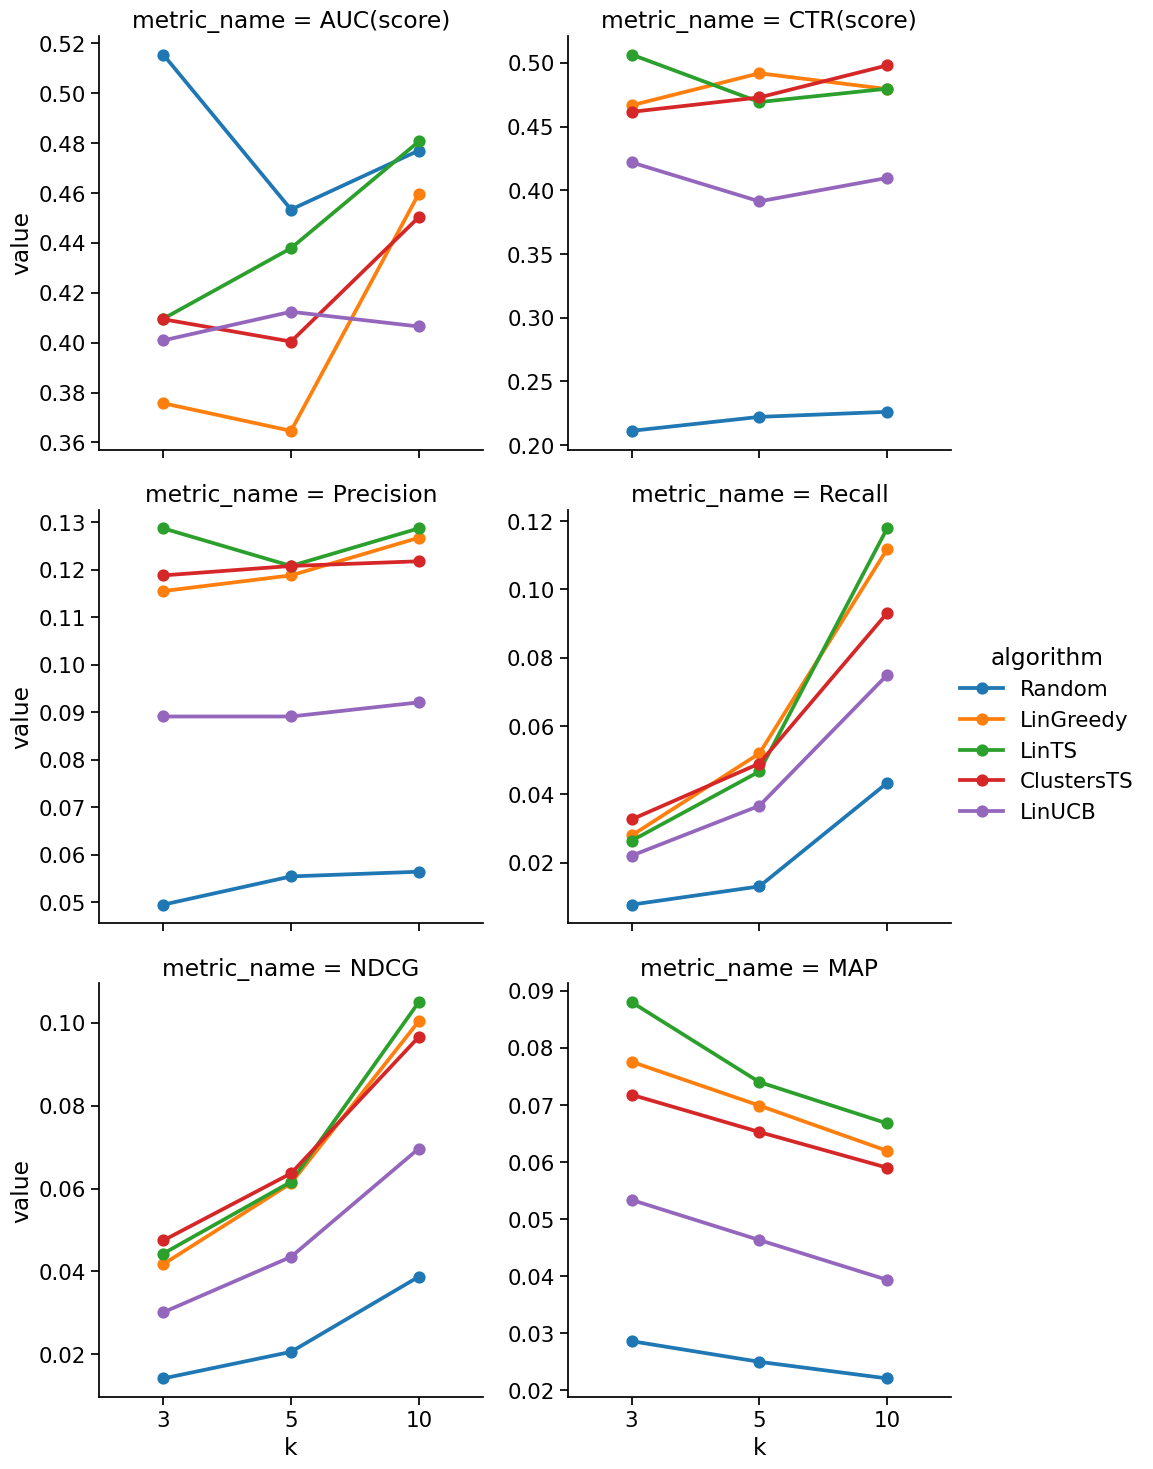

In [7]:
from mab2rec.visualization import plot_metrics_at_k

# Plot each metric across all algorithms at different k
plot_metrics_at_k(reco_to_metrics, col_wrap=2)
print(reco_to_metrics)

Os resultados obtidos foram os mesmos mostrados na biblioteca

Porém, as métricas foram calculadas por eles mesmos, vamos tentar calcular outras métricas, nós mesmos

In [8]:
from mab2rec.pipeline import train

rec = BanditRecommender(learning_policy=LearningPolicy.LinUCB(alpha=1.0), top_k=5)

train(rec, data=train_data, user_features=user_features)

In [9]:
df_test = pd.read_csv(test_data)
user_features_df = pd.read_csv(user_features)
contexts = df_test.merge(user_features_df, on='user_id').drop(columns=['user_id', 'item_id', 'response']).values

recomendations = rec.recommend(contexts)

df_test = df_test.reset_index(drop=True)

hits = 0
for i, interaction in df_test.iterrows():
    if interaction['item_id'] in recomendations[i]:
        hits += 1

print(f'Hits: {hits}')
print(f'Total: {len(df_test)}')
print(f'HR: {hits/len(df_test)}')

Hits: 106
Total: 4797
HR: 0.022097144048363562


In [10]:
df_test = pd.read_csv(test_data)
user_features_df = pd.read_csv(user_features)
contexts = user_features_df[user_features_df['user_id'].isin(df_test['user_id'])].drop(columns=['user_id']).values  # Apenas contextos (features dos usuários) presentes no conjunto de teste

recomendations = rec.recommend(contexts)

recs_list = []
for i, user_id in enumerate(df_test['user_id'].unique().tolist()):
    for reco in recomendations[i]:
        recs_list.append([user_id, reco])

df_recs = pd.DataFrame(recs_list, columns=['user_id', 'item_id'])

df_set = df_test.merge(df_recs, on=['user_id', 'item_id'], how='inner')

df_set['response'].mean()

0.391304347826087

Com topN (topk) = 5, o resultado do CTR deu exatamente o mesmo que foi calculado pela lib

## Agora, vamos tentar fazer o mesmo usando as nossas embeddings ao invés de usar a deles

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
df_train = pd.read_csv(train_data)
df_test = pd.read_csv(test_data)

df_full = pd.concat([df_train, df_test])

df_full['user_id'] = LabelEncoder().fit_transform(df_full['user_id'])
df_full['item_id'] = LabelEncoder().fit_transform(df_full['item_id'])

df_train = df_full.iloc[:len(df_train)]
df_test = df_full.iloc[len(df_train):]

In [13]:
import implicit
from scipy.sparse import csr_matrix
from implicit.nearest_neighbours import bm25_weight

num_users = df_full['user_id'].nunique()
num_items = df_full['item_id'].nunique()

import numpy as np

In [14]:
# Cria a matriz esparsa
sparse_matrix = csr_matrix((np.ones(len(df_train)), (df_train['user_id'], df_train['item_id'])), shape=(num_users, num_items))
sparse_matrix = bm25_weight(sparse_matrix, K1=100, B=0.8)

# Treina o modelo
model = implicit.als.AlternatingLeastSquares(factors=100)
model.fit(sparse_matrix)

print(model.user_factors)

  0%|          | 0/15 [00:00<?, ?it/s]

[[-0.64580876  0.3531851  -1.6998596  ...  0.26922286 -0.5530126
   0.2847065 ]
 [-0.20827374 -0.45200372  1.5306668  ...  0.547812   -1.1290851
   1.050714  ]
 [ 0.45111084  0.7627184   0.32422414 ...  0.90130943  1.198096
   0.4558765 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.5274959   0.8222789  -0.01090167 ...  0.9951193   0.83993745
   1.189525  ]
 [-0.2738855   0.32477683 -0.23295517 ...  0.14044285  0.45338663
   0.52005535]]


In [15]:
user_features_list = []

for user_id in df_train['user_id'].unique():
    user_factors = model.user_factors[user_id]
    user_features_list.append([user_id] + list(user_factors))

df_user_features = pd.DataFrame(user_features_list, columns=['user_id'] + [f'u{i}' for i in range(100)])
df_user_features

,user_id,u0,u1,u2,u3,u4,u5,u6,u7,u8,...,u90,u91,u92,u93,u94,u95,u96,u97,u98,u99
0,842,-1.498284,-0.235373,-0.789941,-0.299423,-0.547776,1.641273,-0.269730,2.426815,0.311270,...,0.639943,-1.942420,0.535932,0.223419,-0.009669,0.851946,-1.185404,0.634911,0.715674,-0.709523
1,143,1.403623,0.601430,2.654535,-0.629883,0.962883,-0.566281,1.163654,-0.179122,0.537640,...,-0.000056,1.079561,1.398787,0.622074,1.165257,0.419212,2.265089,-1.079061,0.354467,1.658335
2,600,1.106782,0.452527,-0.837928,0.583275,-0.681947,-0.645704,2.257622,-1.924031,1.717795,...,1.881728,1.174842,1.875784,1.530405,1.932741,1.181824,0.680833,-1.013949,0.198031,-0.625696
3,750,0.666856,3.229915,-1.356651,1.061437,1.921494,1.009993,2.819652,0.668760,1.251039,...,1.484853,0.885204,0.121551,1.526280,0.121392,-0.462910,-0.113686,0.273507,-0.739061,-0.435200
4,200,-1.860026,2.121490,1.367068,1.352570,2.048846,0.400142,-0.614597,1.618664,2.196427,...,0.721133,0.455246,1.383521,0.534556,0.710928,1.814609,2.570852,2.688818,0.447702,1.097443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,924,1.033463,0.433094,-0.066129,0.109288,-0.339437,0.332392,0.929325,0.749509,-0.371000,...,0.749349,-0.129614,-1.868132,0.372880,-0.361336,-1.454442,0.246378,1.469601,1.583692,1.437664
892,854,0.066458,-0.519144,-0.282068,0.120775,0.805800,-0.316679,-0.034761,-0.094591,0.307821,...,-0.087373,0.305556,-0.280251,-0.077624,0.613947,-0.425322,-0.210880,-0.741023,-0.225663,0.499581
893,4,0.502761,0.060208,0.425650,0.198696,-0.011092,0.134898,0.203895,0.734529,0.638364,...,-0.493398,0.815681,-0.092602,-0.630207,-0.125711,0.074043,0.307629,0.100374,0.164652,-0.531882
894,674,0.680359,0.688316,0.546552,0.113238,-0.056603,-0.584378,0.242583,0.701868,-0.713437,...,-0.078212,-0.601274,1.006179,-0.440282,0.549014,0.295501,0.487124,-0.110439,0.813348,-0.149895


In [16]:
reco_to_results, reco_to_metrics = benchmark(recommenders, 
                                             metrics=metrics,
                                             train_data=df_train, 
                                             test_data=df_test,
                                             user_features=df_user_features)

{'Random': {'AUC(score)@3': 0.5154761904761904, 'CTR(score)@3': 0.2112676056338028, 'Precision@3': 0.04950495049504949, 'Recall@3': 0.00774496333427291, 'NDCG@3': 0.014186541542204544, 'MAP@3': 0.0286028602860286, 'AUC(score)@5': 0.45335276967930027, 'CTR(score)@5': 0.2222222222222222, 'Precision@5': 0.05544554455445545, 'Recall@5': 0.013086241155909124, 'NDCG@5': 0.02060279415286892, 'MAP@5': 0.024983498349834984, 'AUC(score)@10': 0.47701304543409806, 'CTR(score)@10': 0.2261904761904762, 'Precision@10': 0.05643564356435644, 'Recall@10': 0.04335860418853606, 'NDCG@10': 0.03872990879686032, 'MAP@10': 0.022072379006608144}, 'LinGreedy': {'AUC(score)@3': 0.4391666666666667, 'CTR(score)@3': 0.4, 'Precision@3': 0.066006600660066, 'Recall@3': 0.010383365060506687, 'NDCG@3': 0.02308953348188582, 'MAP@3': 0.04950495049504951, 'AUC(score)@5': 0.47629629629629633, 'CTR(score)@5': 0.35064935064935066, 'Precision@5': 0.05346534653465347, 'Recall@5': 0.015182307379410679, 'NDCG@5': 0.02792766710897

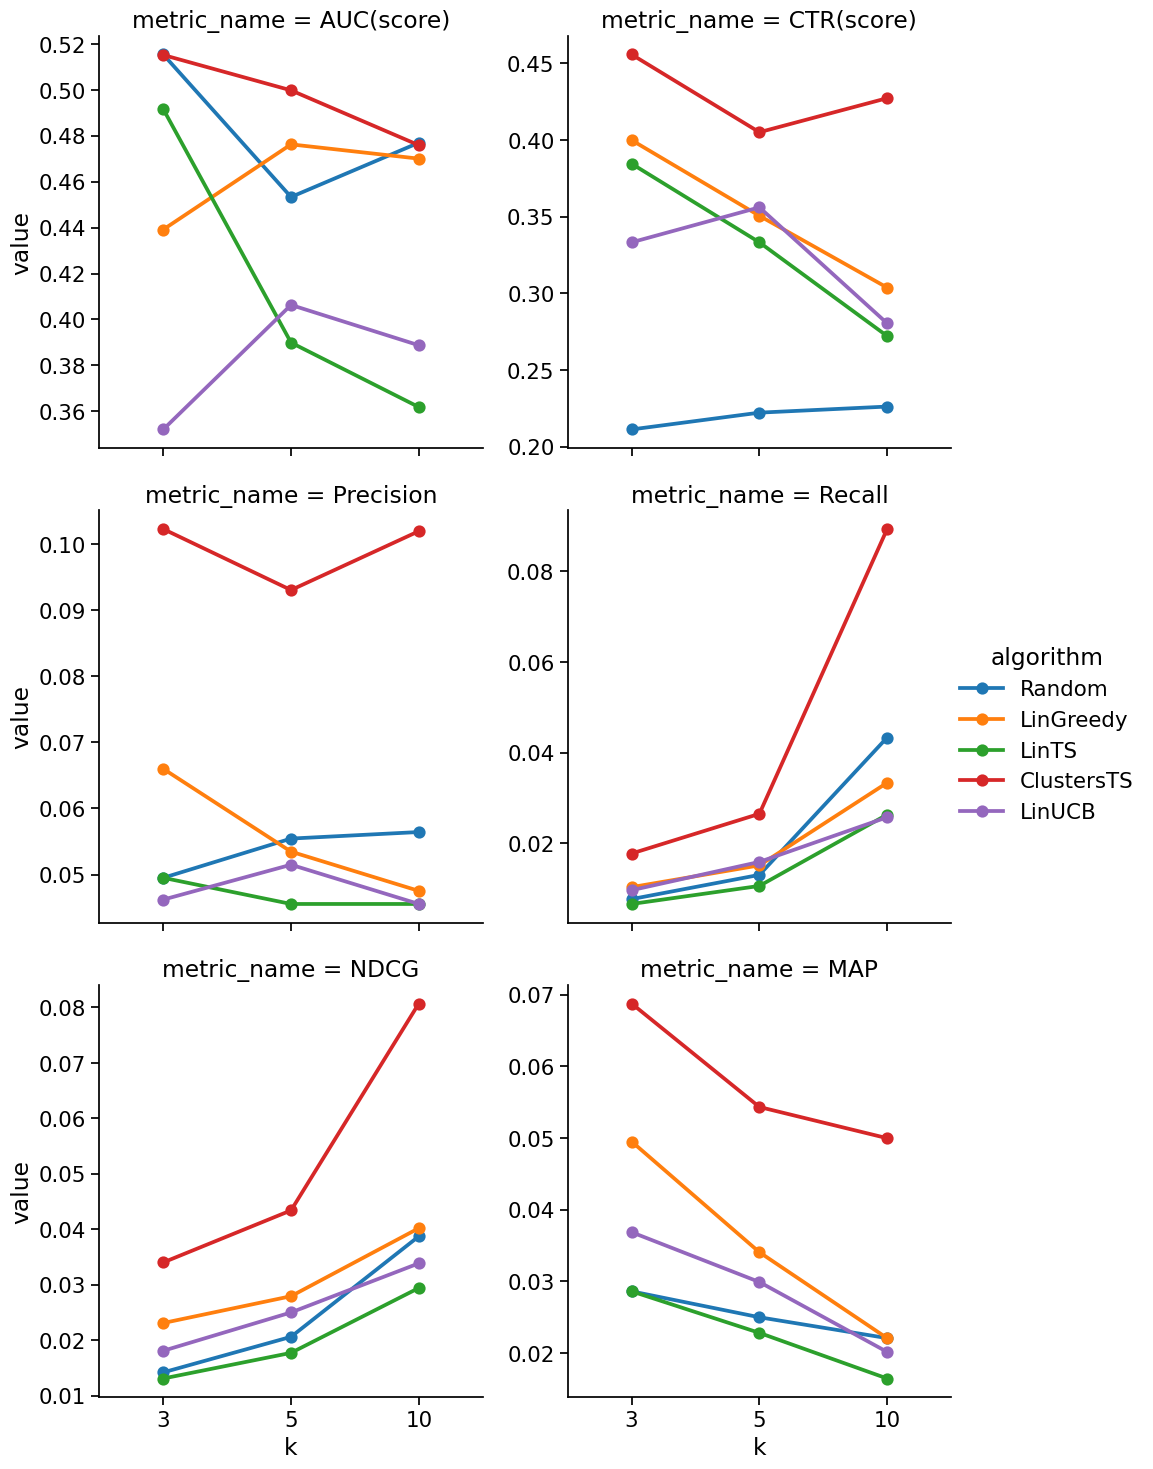

In [17]:
# Plot each metric across all algorithms at different k
plot_metrics_at_k(reco_to_metrics, col_wrap=2)
print(reco_to_metrics)

In [18]:
df_test['user_id'].isin(df_train['user_id']).value_counts()

True     2839
False    1958
Name: user_id, dtype: int64

In [19]:
df_test = df_test[df_test['user_id'].isin(df_train['user_id'])]
len(df_test)

2839

In [20]:
reco_to_results, reco_to_metrics = benchmark(recommenders, 
                                             metrics=metrics,
                                             train_data=df_train, 
                                             test_data=df_test,
                                             user_features=df_user_features)

{'Random': {'AUC(score)@3': 0.4584615384615385, 'CTR(score)@3': 0.34210526315789475, 'Precision@3': 0.07878787878787878, 'Recall@3': 0.03178009864674882, 'NDCG@3': 0.03250214110768952, 'MAP@3': 0.054545454545454536, 'AUC(score)@5': 0.46852425180598556, 'CTR(score)@5': 0.2714285714285714, 'Precision@5': 0.0690909090909091, 'Recall@5': 0.037936452097219915, 'NDCG@5': 0.03894923331080372, 'MAP@5': 0.04351515151515152, 'AUC(score)@10': 0.4904717275851296, 'CTR(score)@10': 0.25384615384615383, 'Precision@10': 0.06000000000000001, 'Recall@10': 0.05038760601361447, 'NDCG@10': 0.050086775156823006, 'MAP@10': 0.03491991341991342}, 'LinGreedy': {'AUC(score)@3': 0.4593301435406698, 'CTR(score)@3': 0.36666666666666664, 'Precision@3': 0.06666666666666667, 'Recall@3': 0.009485588485588486, 'NDCG@3': 0.02305339608547501, 'MAP@3': 0.05252525252525252, 'AUC(score)@5': 0.43440860215053767, 'CTR(score)@5': 0.32608695652173914, 'Precision@5': 0.05454545454545456, 'Recall@5': 0.01346827246827247, 'NDCG@5':

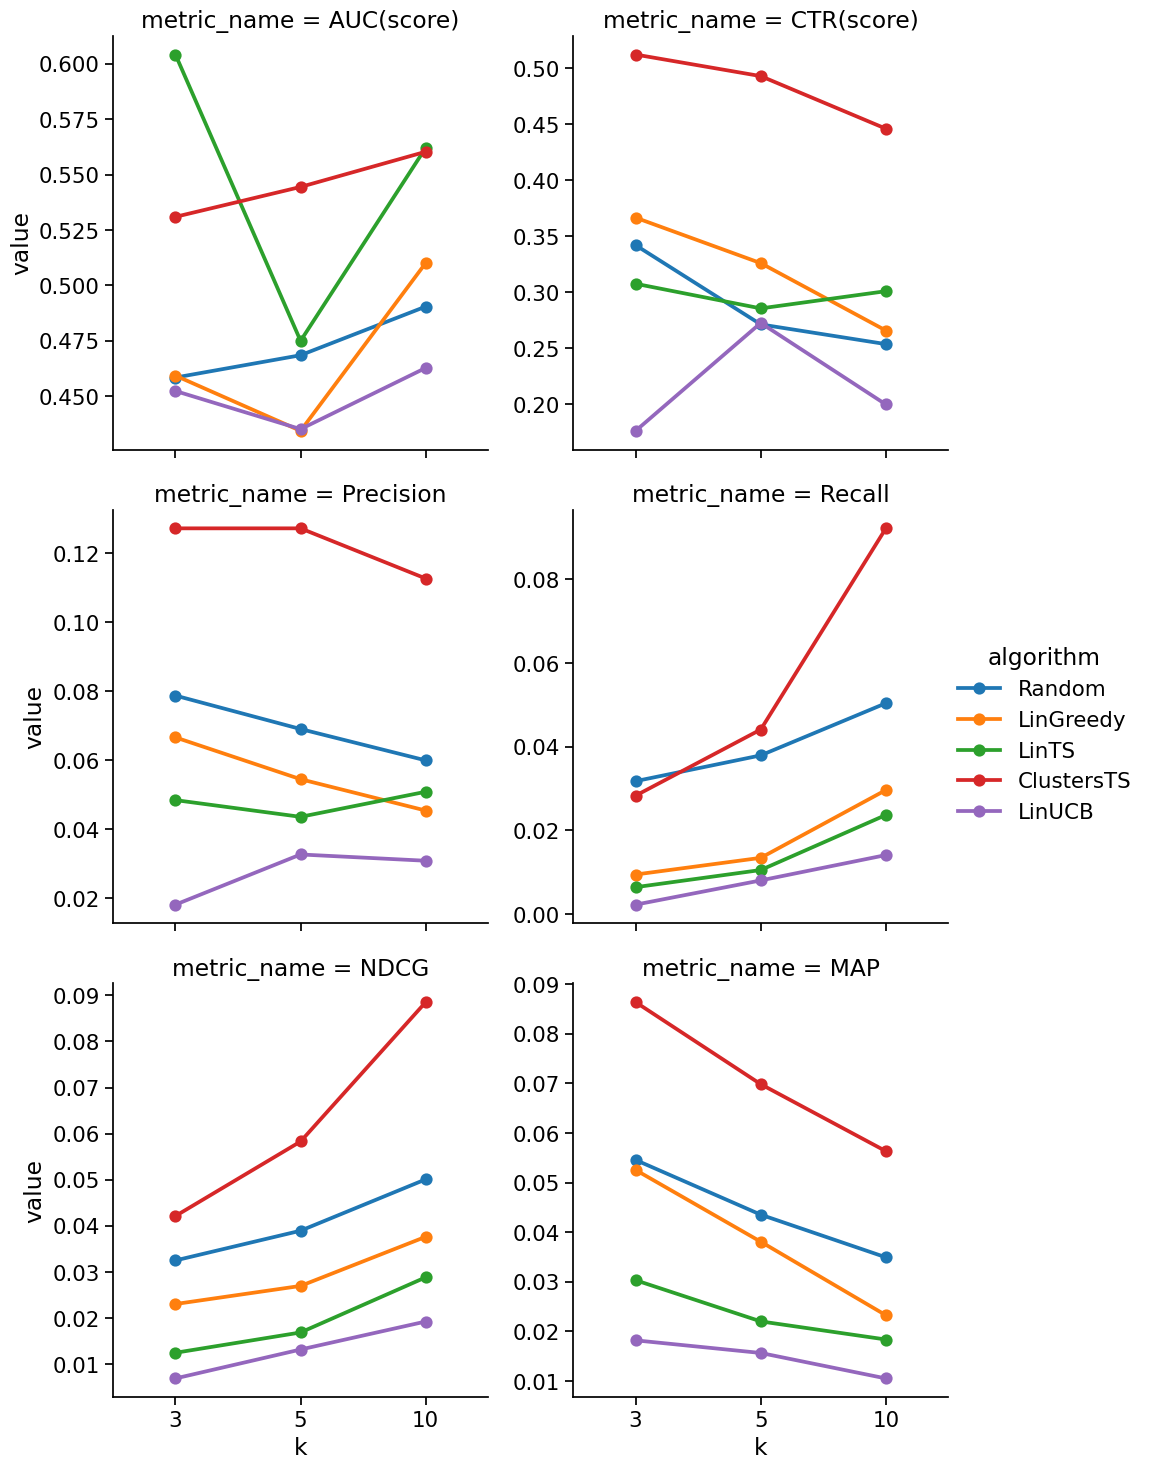

In [21]:
# Plot each metric across all algorithms at different k
plot_metrics_at_k(reco_to_metrics, col_wrap=2)
print(reco_to_metrics)

Não tivemos resultados muito bons... Vamos deixar o código em uma função, para testarmos parâmetros diferentes, e ver se muda algo

In [22]:
def test(use_weight=False, K1=100, B=0.8, factors=100, filter_test=True):
    df_train = pd.read_csv(train_data)
    df_test = pd.read_csv(test_data)

    df_full = pd.concat([df_train, df_test])

    df_full['user_id'] = LabelEncoder().fit_transform(df_full['user_id'])
    df_full['item_id'] = LabelEncoder().fit_transform(df_full['item_id'])

    df_train = df_full.iloc[:len(df_train)]
    df_test = df_full.iloc[len(df_train):]

    if filter_test:
        df_test = df_test[(df_test['user_id'].isin(df_train['user_id'])) & (df_test['item_id'].isin(df_train['item_id'])) & (df_test['response'] == 1)]

    num_users = df_full['user_id'].nunique()
    num_items = df_full['item_id'].nunique()

    # Cria a matriz esparsa
    sparse_matrix = csr_matrix((df_train['response'], (df_train['user_id'], df_train['item_id'])), shape=(num_users, num_items))
    if use_weight:
        updated_sparse_matrix = bm25_weight(sparse_matrix, K1=K1, B=B)
    else:
        updated_sparse_matrix = sparse_matrix

    # Treina o modelo
    model = implicit.als.AlternatingLeastSquares(factors=factors)
    model.fit(updated_sparse_matrix)

    user_features_list = []

    for user_id in df_train['user_id'].unique():
        user_factors = model.user_factors[user_id]
        user_features_list.append([user_id] + list(user_factors))

    df_user_features = pd.DataFrame(user_features_list, columns=['user_id'] + [f'u{i}' for i in range(factors)])

    reco_to_results, reco_to_metrics = benchmark(recommenders, 
                                             metrics=metrics,
                                             train_data=df_train, 
                                             test_data=df_test,
                                             user_features=df_user_features)
    
    plot_metrics_at_k(reco_to_metrics, col_wrap=2)
    print(reco_to_metrics)

    return df_train, df_test, model, sparse_matrix, df_user_features

  0%|          | 0/15 [00:00<?, ?it/s]

{'Random': {'AUC(score)@3': nan, 'CTR(score)@3': 1.0, 'Precision@3': 0.08484848484848484, 'Recall@3': 0.0168937844055036, 'NDCG@3': 0.030383372486294424, 'MAP@3': 0.052525252525252523, 'AUC(score)@5': nan, 'CTR(score)@5': 1.0, 'Precision@5': 0.0690909090909091, 'Recall@5': 0.02270992904517765, 'NDCG@5': 0.03621727889346, 'MAP@5': 0.037333333333333336, 'AUC(score)@10': nan, 'CTR(score)@10': 1.0, 'Precision@10': 0.05818181818181818, 'Recall@10': 0.035443448249285095, 'NDCG@10': 0.04753153880703916, 'MAP@10': 0.02577280743947411}, 'LinGreedy': {'AUC(score)@3': nan, 'CTR(score)@3': 1.0, 'Precision@3': 0.10909090909090907, 'Recall@3': 0.02278163414828432, 'NDCG@3': 0.03661787464389095, 'MAP@3': 0.07474747474747474, 'AUC(score)@5': nan, 'CTR(score)@5': 1.0, 'Precision@5': 0.10181818181818181, 'Recall@5': 0.03427593396611355, 'NDCG@5': 0.04875818030750317, 'MAP@5': 0.06078787878787878, 'AUC(score)@10': nan, 'CTR(score)@10': 1.0, 'Precision@10': 0.10909090909090906, 'Recall@10': 0.086731168699

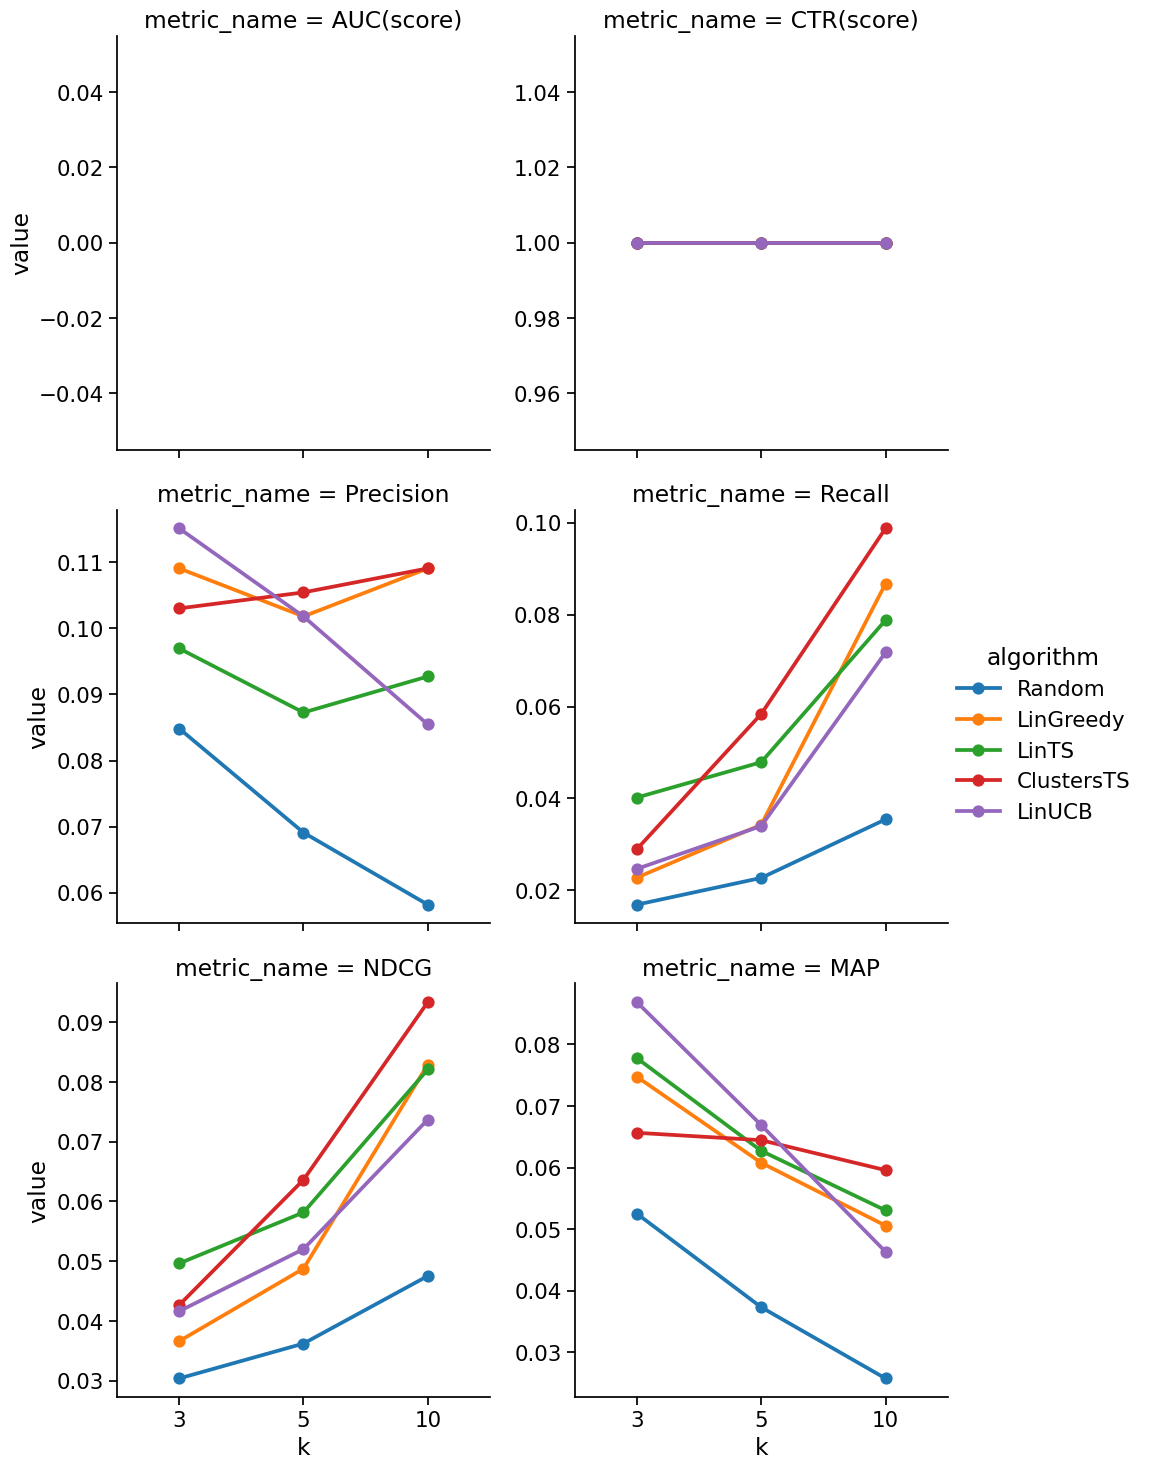

In [23]:
_ = test(
    use_weight=True, 
    K1=100,
    B=0.8,
    factors=10,
    filter_test=True
)

  0%|          | 0/15 [00:00<?, ?it/s]

{'Random': {'AUC(score)@3': nan, 'CTR(score)@3': 1.0, 'Precision@3': 0.08484848484848484, 'Recall@3': 0.0168937844055036, 'NDCG@3': 0.030383372486294424, 'MAP@3': 0.052525252525252523, 'AUC(score)@5': nan, 'CTR(score)@5': 1.0, 'Precision@5': 0.0690909090909091, 'Recall@5': 0.02270992904517765, 'NDCG@5': 0.03621727889346, 'MAP@5': 0.037333333333333336, 'AUC(score)@10': nan, 'CTR(score)@10': 1.0, 'Precision@10': 0.05818181818181818, 'Recall@10': 0.035443448249285095, 'NDCG@10': 0.04753153880703916, 'MAP@10': 0.02577280743947411}, 'LinGreedy': {'AUC(score)@3': nan, 'CTR(score)@3': 1.0, 'Precision@3': 0.1515151515151515, 'Recall@3': 0.035441378408608844, 'NDCG@3': 0.052880739339645454, 'MAP@3': 0.09999999999999998, 'AUC(score)@5': nan, 'CTR(score)@5': 1.0, 'Precision@5': 0.13454545454545458, 'Recall@5': 0.05245159118290172, 'NDCG@5': 0.06826818435163096, 'MAP@5': 0.07917171717171718, 'AUC(score)@10': nan, 'CTR(score)@10': 1.0, 'Precision@10': 0.11818181818181818, 'Recall@10': 0.09014870854

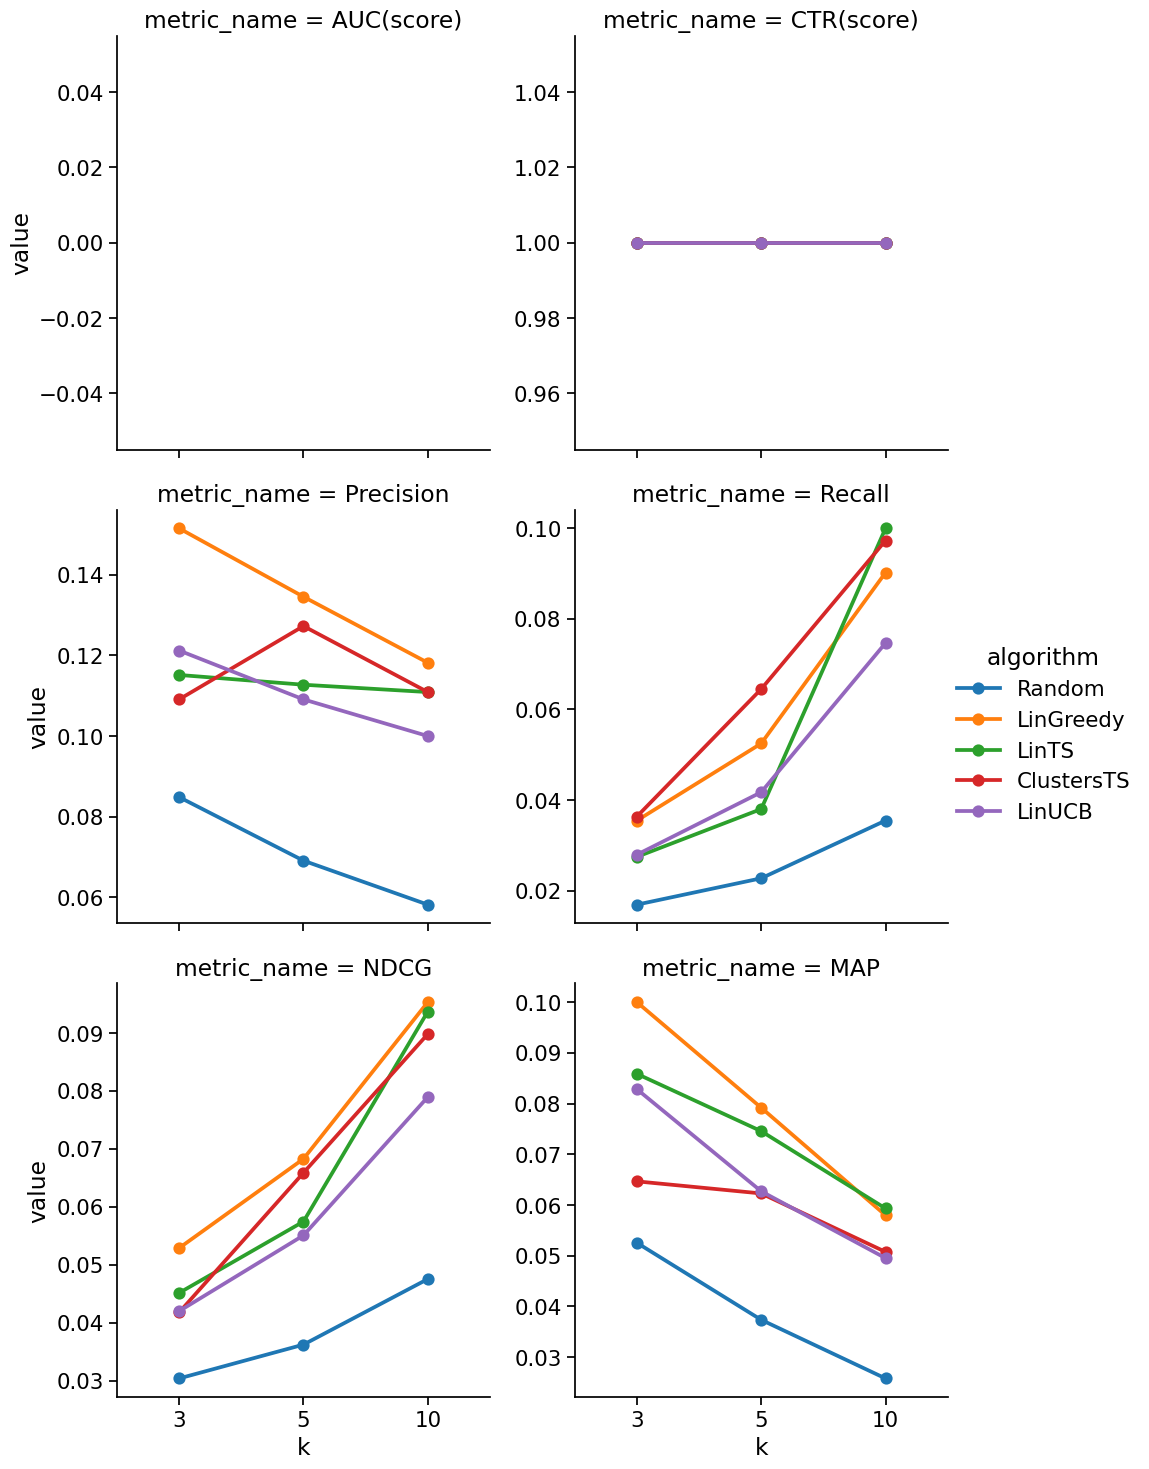

In [24]:
df_train, df_test, model, sparse_matrix, user_features_df = test(
    use_weight=True, 
    K1=100,
    B=0.8,
    factors=10,
    filter_test=True
)

In [25]:
rec = BanditRecommender(learning_policy=LearningPolicy.LinUCB(alpha=1.0), top_k=10)

train(rec, data=df_train, user_features=user_features_df)

contexts = df_test.merge(user_features_df, on='user_id').drop(columns=['user_id', 'item_id', 'response']).values

recomendations = rec.recommend(contexts)

df_test = df_test.reset_index(drop=True)

hits = 0
for i, interaction in df_test.iterrows():
    if interaction['item_id'] in recomendations[i]:
        hits += 1

print(f'Hits: {hits}')
print(f'Total: {len(df_test)}')
print(f'HR: {hits/len(df_test)}')

Hits: 51
Total: 771
HR: 0.06614785992217899


In [26]:
rec = BanditRecommender(learning_policy=LearningPolicy.LinGreedy(), top_k=10)

train(rec, data=df_train, user_features=user_features_df)

contexts = df_test.merge(user_features_df, on='user_id').drop(columns=['user_id', 'item_id', 'response']).values

recomendations = rec.recommend(contexts)

df_test = df_test.reset_index(drop=True)

hits = 0
for i, interaction in df_test.iterrows():
    if interaction['item_id'] in recomendations[i]:
        hits += 1

print(f'Hits: {hits}')
print(f'Total: {len(df_test)}')
print(f'HR: {hits/len(df_test)}')

Hits: 53
Total: 771
HR: 0.06874189364461739


In [27]:
# Cria a matriz esparsa
sparse_matrix = csr_matrix((df_train['response'], (df_train['user_id'], df_train['item_id'])), shape=(num_users, num_items))
updated_sparse_matrix = bm25_weight(sparse_matrix, K1=100, B=0.8)
# Treina o modelo
model = implicit.als.AlternatingLeastSquares(factors=10)
model.fit(updated_sparse_matrix)

hits = 0
for i, interaction in df_test.iterrows():
    ids_recs, recommendations = model.recommend(userid=interaction['user_id'], user_items=sparse_matrix[interaction['user_id']], N=10)
    if interaction['item_id'] in ids_recs:
        hits += 1

print(f'Hits: {hits}')
print(f'Total: {len(df_test)}')
print(f'HR: {hits/len(df_test)}')

  0%|          | 0/15 [00:00<?, ?it/s]

Hits: 95
Total: 771
HR: 0.12321660181582361


## Testando na CiaoDVD

In [28]:
df_full_ciao = pd.read_csv('data/ciaoDVD/interactions-timestamp.csv', sep=';')
df_full_ml100k = pd.concat([pd.read_csv(train_data), pd.read_csv(test_data)])

print(f'Qtd. interações CiaoDVD: {len(df_full_ciao)}')
print(f'Qtd. interações ML100k: {len(df_full_ml100k)}')

Qtd. interações CiaoDVD: 72665
Qtd. interações ML100k: 39340


In [29]:
print(f'Qtd. usuários CiaoDVD: {df_full_ciao["id_user"].nunique()}')
print(f'Qtd. usuários ML100k: {df_full_ml100k["user_id"].nunique()}')
print('\n')
print(f'Qtd. itens CiaoDVD: {df_full_ciao["id_item"].nunique()}')
print(f'Qtd. itens ML100K: {df_full_ml100k["item_id"].nunique()}')

Qtd. usuários CiaoDVD: 17615
Qtd. usuários ML100k: 943


Qtd. itens CiaoDVD: 16121
Qtd. itens ML100K: 201


In [56]:
def test_ciao(use_weight=False, K1=100, B=0.8, factors=100, filter_test=True):
    rename_dict = {
        'id_user': 'user_id',
        'id_item': 'item_id',
        'rating': 'response',
    }

    df_full = pd.read_csv('data/ciaoDVD/interactions-timestamp.csv', sep=';')
    df_full = df_full.sort_values(by='timestamp')
    df_full = df_full.rename(columns=rename_dict)
    df_full = df_full[['user_id', 'item_id', 'response']]
    df_full['user_id'] = LabelEncoder().fit_transform(df_full['user_id'])
    df_full['item_id'] = LabelEncoder().fit_transform(df_full['item_id'])
    df_full['response'] = df_full['response'].apply(lambda x: 1 if x >= 5 else 0)

    df_train = df_full.iloc[:int(len(df_full)*0.9)]
    df_test = df_full.iloc[int(len(df_full)*0.9):]

    if filter_test:
        df_test = df_test[(df_test['user_id'].isin(df_train['user_id'])) & (df_test['item_id'].isin(df_train['item_id'])) & (df_test['response'] >= 1)]

    num_users = df_full['user_id'].nunique()
    num_items = df_full['item_id'].nunique()

    # Cria a matriz esparsa
    sparse_matrix = csr_matrix((df_train['response'], (df_train['user_id'], df_train['item_id'])), shape=(num_users, num_items))
    if use_weight:
        updated_sparse_matrix = bm25_weight(sparse_matrix, K1=K1, B=B)
    else:
        updated_sparse_matrix = sparse_matrix

    # Treina o modelo
    model = implicit.als.AlternatingLeastSquares(factors=factors)
    model.fit(updated_sparse_matrix)

    user_features_list = []

    for user_id in df_train['user_id'].unique():
        user_factors = model.user_factors[user_id]
        user_features_list.append([user_id] + list(user_factors))

    df_user_features = pd.DataFrame(user_features_list, columns=['user_id'] + [f'u{i}' for i in range(factors)])

    reco_to_results, reco_to_metrics = benchmark(recommenders, 
                                             metrics=metrics,
                                             train_data=df_train, 
                                             test_data=df_test,
                                             user_features=df_user_features)
    
    plot_metrics_at_k(reco_to_metrics, col_wrap=2)
    print(reco_to_metrics)

    return df_train, df_test, model, sparse_matrix, df_user_features, model

  0%|          | 0/15 [00:00<?, ?it/s]

{'Random': {'Precision@3': 0.0, 'Recall@3': 0.0, 'NDCG@3': 0.0, 'MAP@3': 0.0, 'Precision@5': 0.0, 'Recall@5': 0.0, 'NDCG@5': 0.0, 'MAP@5': 0.0, 'Precision@10': 0.0, 'Recall@10': 0.0, 'NDCG@10': 0.0, 'MAP@10': 0.0}, 'LinGreedy': {'Precision@3': 0.0, 'Recall@3': 0.0, 'NDCG@3': 0.0, 'MAP@3': 0.0, 'AUC(score)@5': nan, 'CTR(score)@5': 1.0, 'Precision@5': 0.003278688524590164, 'Recall@5': 0.0005159283804208812, 'NDCG@5': 0.0007021990290004869, 'MAP@5': 0.0007377049180327869, 'AUC(score)@10': nan, 'CTR(score)@10': 1.0, 'Precision@10': 0.002459016393442623, 'Recall@10': 0.001686888567774511, 'NDCG@10': 0.001453227261006746, 'MAP@10': 0.0005361324857811977}, 'LinTS': {'AUC(score)@3': nan, 'CTR(score)@3': 1.0, 'Precision@3': 0.00273224043715847, 'Recall@3': 0.00017439832577607255, 'NDCG@3': 0.0006628351392348177, 'MAP@3': 0.00273224043715847, 'AUC(score)@5': nan, 'CTR(score)@5': 1.0, 'Precision@5': 0.004918032786885246, 'Recall@5': 0.001745436577142193, 'NDCG@5': 0.0020967461855374804, 'MAP@5': 

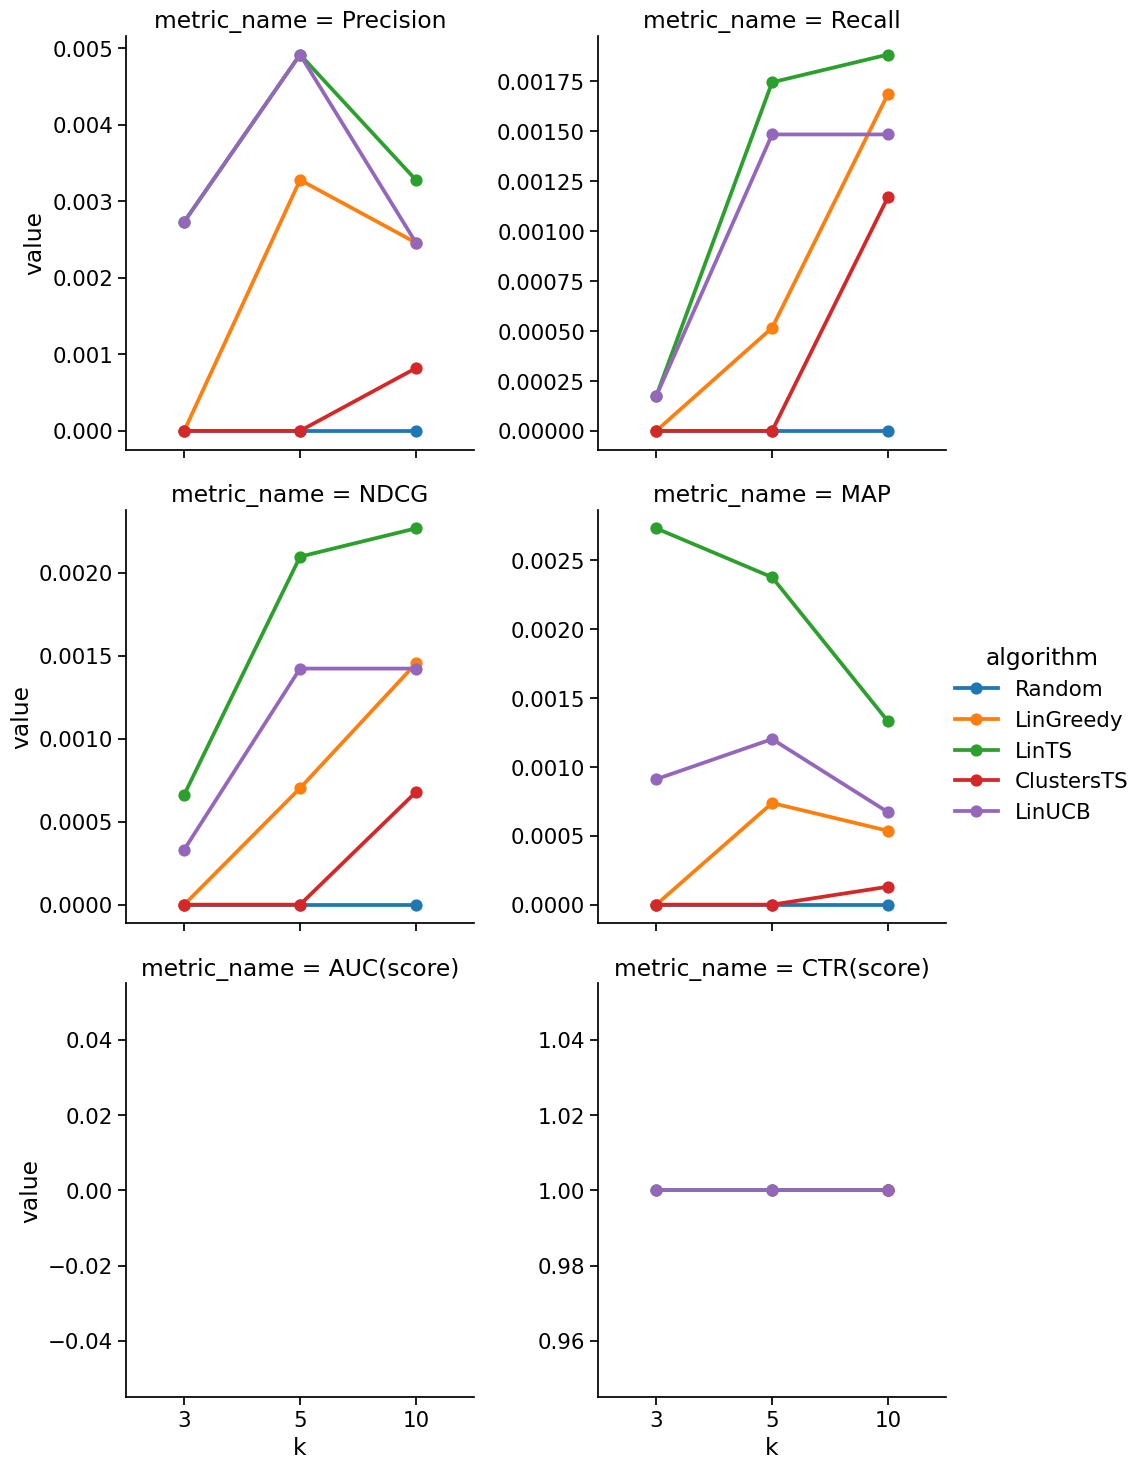

In [57]:
df_train, df_test, model, sparse_matrix, user_features_df, model = test_ciao(
    use_weight=True, 
    K1=100,
    B=0.8,
    factors=10,
    filter_test=True
)

In [58]:
rec = BanditRecommender(learning_policy=LearningPolicy.LinUCB(alpha=1.0), top_k=10)

train(rec, data=df_train, user_features=user_features_df)

contexts = df_test.merge(user_features_df, on='user_id').drop(columns=['user_id', 'item_id', 'response']).values

recomendations = rec.recommend(contexts)

df_test = df_test.reset_index(drop=True)

hits = 0
for i, interaction in df_test.iterrows():
    if interaction['item_id'] in recomendations[i]:
        hits += 1

print(f'Hits: {hits}')
print(f'Total: {len(df_test)}')
print(f'HR: {hits/len(df_test)}')

Hits: 7
Total: 715
HR: 0.009790209790209791


In [59]:
rec = BanditRecommender(learning_policy=LearningPolicy.LinGreedy(), top_k=10)

train(rec, data=df_train, user_features=user_features_df)

contexts = df_test.merge(user_features_df, on='user_id').drop(columns=['user_id', 'item_id', 'response']).values

recomendations = rec.recommend(contexts)

df_test = df_test.reset_index(drop=True)

hits = 0
for i, interaction in df_test.iterrows():
    if interaction['item_id'] in recomendations[i]:
        hits += 1

print(f'Hits: {hits}')
print(f'Total: {len(df_test)}')
print(f'HR: {hits/len(df_test)}')

Hits: 6
Total: 715
HR: 0.008391608391608392


In [60]:

hits = 0
for i, interaction in df_test.iterrows():
    ids_recs, recommendations = model.recommend(userid=interaction['user_id'], user_items=sparse_matrix[interaction['user_id']], N=10)
    if interaction['item_id'] in ids_recs:
        hits += 1

print(f'Hits: {hits}')
print(f'Total: {len(df_test)}')
print(f'HR: {hits/len(df_test)}')

Hits: 5
Total: 715
HR: 0.006993006993006993
